In [1]:
# author: Nikita Susan Easow
# date: 2022-11-24

"""
Takes the preprocessed training and test data and does cross validation with logistic regression and svm classifier - finds logistic regression to be the better model and does hyperparameter tuning to get the best hyperparameters. It then fits this trained model on the unseen data (test dataset).
   
Usage: src/fit_new_york_grading_prediction_model.py --train_data=<train_input_file> --test_data=<test_input_file> --output_dir=<output_directory>
Options:
--train_data=<train_input_file>       Path of the input file that contains the train data
--test_data=<test_input_file>         Path of the input file that contains the test data
--output_dir=<output_directory>       Path of the output file where results of the analysis will be stored 
Command to run the script:
python src/fit_new_york_grading_prediction_model.py --train_data="./data/processed/train_df.csv" --test_data="./data/processed/test_df.csv" --output_dir="./results/"
"""

# REFERENCE : code to plot PR curve referred from 573 lecture 1 notes

from docopt import docopt
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats import randint
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import os

# read train and test data from csv files

print("Reading data from CSV files...")
train_df = pd.read_csv("../data/processed/train_df.csv")
test_df = pd.read_csv("../data/processed/test_df.csv")

# split features and target for train and test data

X_train = train_df.drop(columns=["grade"])
y_train = train_df["grade"]

X_test = test_df.drop(columns=["grade"])
y_test = test_df["grade"]

# feature transformation
# camis: dropped, these are unique identifiers
# dba: dropped
# boro: OHE on categorical variable 
# zipcode: OHE on categorical variable
# cuisine_description: OHE on categorical variable
# inspection_date: dropped, not relevant
# action: OHE on categorical variable
# violation_code: OHE on categorical variable
# violation_description: text with CountVectorizer()
# critical_flag: OHEon categorical variable
# score: passthrough feature
# inspection_type: dropped, not relevant - may introduce noise

categorical_features = ['boro', 'zipcode', 'cuisine_description', 'action', 'violation_code', 'violation_description', 'critical_flag']
passthrough_features = ['score']
drop_features = ['camis', 'dba', 'inspection_date', 'inspection_type']
text_features = 'violation_description'

# column transformer
preprocessor = make_column_transformer( 
    ("passthrough", passthrough_features),  
    (OneHotEncoder(handle_unknown="ignore", sparse=False, max_categories=20), categorical_features),  
    (CountVectorizer(stop_words="english", max_features=2000), text_features),
    ("drop", drop_features)
)

# cross validations for dummy, logistic regression and svm classifier

# Cross validation takes roughly 7 minutes

print("Performing cross validations for dummy, logistic regression and svm classifier...")
cross_val_results = {}
dc = DummyClassifier()
print("dummy")
cross_val_results['dummy'] = cross_validate(dc, X_train, y_train, return_train_score=True, scoring=make_scorer(f1_score, pos_label='F'))
pipe_lr = make_pipeline(preprocessor, LogisticRegression(random_state=123, max_iter=2000))
print("logreg")
cross_val_results['logreg'] = cross_validate(pipe_lr, X_train, y_train, return_train_score=True, scoring=make_scorer(f1_score, pos_label='F'))
pip_svc = make_pipeline(preprocessor, SVC(random_state=123))
print("svc")
#cross_val_results['svc'] = cross_validate(pip_svc, X_train, y_train, return_train_score=True, scoring=make_scorer(f1_score, pos_label='F'))

print(cross_val_results)

Reading data from CSV files...
Performing cross validations for dummy, logistic regression and svm classifier...
dummy
logreg
svc
{'dummy': {'fit_time': array([0.03045154, 0.02900195, 0.03071213, 0.026757  , 0.03199887]), 'score_time': array([0.0647788 , 0.0582881 , 0.0808363 , 0.05870295, 0.06330323]), 'test_score': array([0., 0., 0., 0., 0.]), 'train_score': array([0., 0., 0., 0., 0.])}, 'logreg': {'fit_time': array([5.17538857, 3.86554456, 5.58922744, 5.29286742, 5.9030838 ]), 'score_time': array([0.33374405, 0.39386106, 0.3995955 , 0.38831186, 0.38532209]), 'test_score': array([0.07939317, 0.07625826, 0.078125  , 0.08360614, 0.08437971]), 'train_score': array([0.0794987 , 0.07843137, 0.08441844, 0.08217279, 0.0876004 ])}}


In [13]:
cross_val_results['svc'] = cross_validate(pip_svc, X_train, y_train, return_train_score=True, scoring=make_scorer(f1_score, pos_label='F'))

In [2]:
# fitting the logistic regression model to train data because validation scores for LR is higher
print("Fitting the logistic regression model to train data because validation scores for LR is higher")
pipe_lr.fit(X_train, y_train)

Fitting the logistic regression model to train data because validation scores for LR is higher


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=20,
                                                                sparse=False),
                                                  ['boro', 'zipcode',
                                                   'cuisine_description',
                                                   'action', 'violation_code',
                                                   'violation_description',
                                                   'critical_flag']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'violation_description'),
                                                 ('drop', 'drop',
                                                  ['camis', 'dba',
                                                   'inspection_date',
                                                   'inspection_type',
                                                   'score'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, random_state=123))])

In [3]:
# get total length of vocabulary in count vectorizer for 'violation_description' column
len_vocab_1 = len(pipe_lr.named_steps["columntransformer"].named_transformers_["countvectorizer"].get_feature_names_out())
len_vocab_1

335

In [4]:

# hyper parameter tuning for logistic regression model using randomizedsearchcv

# hyper parameter optimization may take upto 15 minutes

print("\nPerforming hyper parameter tuning for logistic regression model using randomizedsearchcv...")
param_dist = {'logisticregression__C': loguniform(1e-3, 1e3),
'columntransformer__countvectorizer__max_features': randint(1, len_vocab_1),
'logisticregression__class_weight':['balanced', None],
"logisticregression__solver" : ["sag"]}
random_search = RandomizedSearchCV(pipe_lr, param_dist, n_iter=10, n_jobs=-1, return_train_score=True, scoring=make_scorer(f1_score, pos_label='F'))
print("Fitting the optimized model")
random_search.fit(X_train, y_train)


Performing hyper parameter tuning for logistic regression model using randomizedsearchcv...
Fitting the optimized model


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             max_categories=20,
                                                                                             sparse=False),
                                                                               ['boro',
                                                                                'zipcode',
                                                                                'cuisine_description',
                                                                                'action',
                                                                                'violation_code',
                                                                                'violation_description',
                                                                                'critical_flag']),
                                                                              ('countvectorizer',
                                                                               CountVectorizer(max_features=2000,
                                                                                               stop...
                   param_distributions={'columntransformer__countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018E939AC0D0>,
                                        'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018E93D73390>,
                                        'logisticregression__class_weight': ['balanced',
                                                                             None],
                                        'logisticregression__solver': ['sag']},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, pos_label=F))

In [5]:
random_search.best_params_

{'columntransformer__countvectorizer__max_features': 80,
 'logisticregression__C': 0.6930605534498594,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__solver': 'sag'}

In [6]:
# obtaining the best parameters
best_parameters = random_search.best_params_

print("Best parameters found to be: ", best_parameters)

# transform data using parameters found from randomized cross validation
preprocessor = make_column_transformer( 
    #("passthrough", passthrough_features),  
    (OneHotEncoder(handle_unknown="ignore", sparse=False, max_categories=20), categorical_features),  
    (CountVectorizer(max_features=best_parameters["columntransformer__countvectorizer__max_features"], stop_words="english"), text_features),
    ("drop", drop_features)
)
pipe_lr_best = make_pipeline(preprocessor, LogisticRegression(C=best_parameters["logisticregression__C"], class_weight=best_parameters["logisticregression__class_weight"], random_state=123, max_iter=2500, solver='sag'))

# cross validation on the best logistic regression model

print("\nDoing cross validation using the best parameters...")
cross_val_results['logreg_best'] = cross_validate(pipe_lr_best, X_train, y_train, return_train_score=True, scoring=make_scorer(f1_score, pos_label='F'))


Best parameters found to be:  {'columntransformer__countvectorizer__max_features': 80, 'logisticregression__C': 0.6930605534498594, 'logisticregression__class_weight': 'balanced', 'logisticregression__solver': 'sag'}

Doing cross validation using the best parameters...


In [7]:
for i, j in cross_val_results.items():
    for l,m in j.items():
        j[l] = m.mean()
final_cross_val_results = pd.DataFrame(cross_val_results)
final_cross_val_results

,dummy,logreg,logreg_best
fit_time,0.029784,5.165222,28.019613
score_time,0.065182,0.380167,0.370610
test_score,0.000000,0.080352,0.412610
train_score,0.000000,0.082424,0.413664


In [8]:
# fit the best model on the training data

print("\nFitting the best model on training data...")
pipe_lr_best.fit(X_train, y_train)


Fitting the best model on training data...


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=20,
                                                                sparse=False),
                                                  ['boro', 'zipcode',
                                                   'cuisine_description',
                                                   'action', 'violation_code',
                                                   'violation_description',
                                                   'critical_flag']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=80,
                                                                  stop_words='english'),
                                                  'violation_description'),
                                                 ('drop', 'drop',
                                                  ['camis', 'dba',
                                                   'inspection_date',
                                                   'inspection_type',
                                                   'score'])])),
                ('logisticregression',
                 LogisticRegression(C=0.6930605534498594,
                                    class_weight='balanced', max_iter=2500,
                                    random_state=123, solver='sag'))])

In [9]:
# score the best model on the test data
score = pipe_lr_best.score(X_test, y_test)
print("Score on test data : ", score)

Score on test data :  0.6491555103654748



Creating and saving PR curve plot...


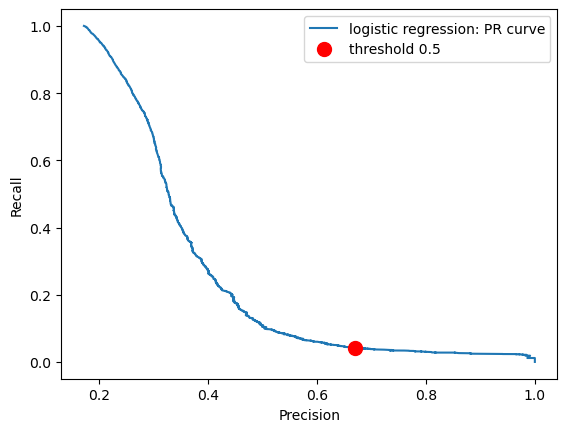

In [11]:
# create and save PR curve for the best model

print("\nCreating and saving PR curve plot...")
precision, recall, thresholds = precision_recall_curve(
y_test, pipe_lr.predict_proba(X_test)[:, 1], pos_label="F"
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, pipe_lr.predict(X_test), pos_label="F"),
    recall_score(y_test, pipe_lr.predict(X_test), pos_label="F"),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");
plt.savefig('../results/' + 'logistic_regression_PR_curve.png')

In [12]:
# saving the model
filename = 'finalized_model.sav'
pickle.dump(pipe_lr, open('../results/' + filename, 'wb'))

# to load the model
# loaded_model = pickle.load(open(output_dir + filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)